In [1]:
import os
import pyabf
import numpy as np
import scipy as sp
from tqdm import tqdm

from scipy.signal import medfilt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import glob  
import seaborn as sns
import pandas as pd
import csv

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


In [2]:
colors = plt.cm.Accent(np.linspace(0, 1, 10))


In [3]:
#### utils
def extract_paired(data_path):
    '''
    input: path string
    output: raw data (see dict)
    '''
    data_tmp = pyabf.ABF(data_path)    
        
    data_tmp.setSweep(sweepNumber=0, channel=0) 
    ch1 = data_tmp.sweepY

    times = data_tmp.sweepX

    # muscle
    data_tmp.setSweep(sweepNumber=0, channel=1) 
    ch2 = data_tmp.sweepY


    return {
            'data':[times, ch1, ch2],
            'misc':data_tmp,
           }


degrees_from_Vs = lambda Vs: np.interp(Vs,[0,5],[0,360])
get_ifr = lambda peak_times: 1/np.diff(peak_times)


def get_stim_param(thetas, strip_id, stim_params, angle):
    '''
    get the stim value at a given angle for a given strip
    
    input: 
        thetas [list] of wanted angles
        strip [array] of all stim angles
        strip [array] of all stim values at angles
    '''
    
    stim_values_at_angles = []
    for theta in thetas:
        idx = np.abs(angle - theta).argmin()
        stim_value = stim_params[:,strip_id][idx]
        stim_values_at_angles.append(stim_value)
        
    return stim_values_at_angles


def get_stimuli_pattern():
    rows = []
    with open('BarPatternParams.txt', newline='', 
                             encoding='mac_roman') as csvfile:
        spamreader = csv.reader(csvfile, delimiter='\t')
        for row in spamreader:
            rows.append(row)

    headers = rows[0]
    stim_params = np.array(rows[3:], dtype =float)
    
    stim_params = np.append(stim_params, np.expand_dims(np.flip(stim_params[:,5]), axis=1), axis=1)
    
    ## add xtra strip pattern
    xtra_strip_params = np.zeros_like(stim_params[:,0])
    xtra_strip_params[:len(xtra_strip_params)//3] = 350
    xtra_strip_params[len(xtra_strip_params)//3:
                      len(xtra_strip_params)*2//3] = 100
    xtra_strip_params[len(xtra_strip_params)*2//3:] = 350
    
    

    stim_params = np.append(stim_params, np.expand_dims(xtra_strip_params, axis=1), axis=1)

    return stim_params

stim_params = get_stimuli_pattern()

In [4]:
f_name = '../../data/5_h1/21o25003.abf'
data = extract_paired(f_name)
trace = -1*data['data'][1]
times = data['data'][0]
drum_loc = degrees_from_Vs(data['data'][2])

In [5]:
# peaks, properties = find_peaks(trace, height=100, distance=25)  
peaks, properties = find_peaks(trace, height=100, prominence=20, wlen=5)  

peak_heights = trace[peaks] 
peak_times = trace[peaks] 

# filt_peaks = []

# for i in range(len(peaks)):
#     x1 = min(trace[properties["left_bases"][i]], trace[properties["right_bases"][i]]) 
#     if peak_heights[i] - x1  > 0:              
#         filt_peaks.append(peaks[i])



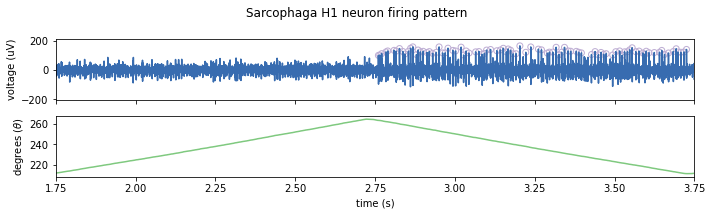

In [6]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,3))
plt.suptitle('Sarcophaga H1 neuron firing pattern')
axes[0].plot(times, trace, c=colors[5],
                     label='action potentials')
axes[0].scatter(times[peaks], trace[peaks],
               facecolors='none', edgecolors=colors[2], 
                label='peaks')
#axes[0].set_xlabel('time (s)')
axes[0].set_ylabel('voltage (uV)')

axes[1].plot(times, drum_loc, c=colors[1], label='Drum position')
axes[1].set_xlabel('time (s)')
axes[1].set_ylabel(r'degrees ($\theta$)')

axes[1].set_xlim(1.75,3.75)
#fig.legend(loc='center right', bbox_to_anchor=[1.2,.5])
plt.tight_layout()
plt.show()

In [31]:
def import_file_get_peaks(f_name, file_type='ccw'):
    data = extract_paired(f_name)
    trace = -1*data['data'][1]
    times = data['data'][0]
    drum_loc = degrees_from_Vs(data['data'][2])

    peaks, properties = find_peaks(trace, height=100, prominence=20, wlen=5)  
    if file_type=='osc':
        pos_peaks,_ = find_peaks(drum_loc,height=np.mean(drum_loc), distance=20000) 
        pos_peaks1,_ = find_peaks(-1*drum_loc,height=-1.5*np.mean(drum_loc), distance=20000) 
    elif file_type=='ccw':
        pos_peaks,_ = find_peaks(drum_loc,height=np.mean(drum_loc), distance=50000) 
        pos_peaks1,_ = find_peaks(-1*drum_loc,height=-1.5*np.mean(drum_loc), distance=50000) 
        
    all_pos_peaks = np.concatenate((pos_peaks,pos_peaks1))
    all_pos_peaks.sort(kind='mergesort')
    
    return trace, times, drum_loc, peaks, all_pos_peaks

trace, times, drum_loc, peaks, all_pos_peaks =\
    import_file_get_peaks('../../data/5_h1/21o25011.abf')

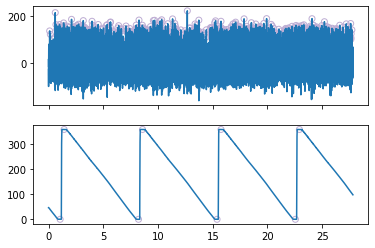

In [32]:
def plot_peak_sorting_outcome(trace, times, drum_loc, peaks, all_pos_peaks):
    fig, axes = plt.subplots(2,1, sharex=True)

    axes[0].plot(times, trace)
    axes[0].scatter(times[peaks], trace[peaks],
               facecolors='none', edgecolors=colors[2], 
                label='peaks')
    axes[1].plot(times, drum_loc)
    axes[1].scatter(times[all_pos_peaks], drum_loc[all_pos_peaks],
               facecolors='none', edgecolors=colors[2], 
                label='trial boundaries')
    plt.show()
    
plot_peak_sorting_outcome(trace, times, drum_loc, peaks, all_pos_peaks)

In [33]:
def print_revolution(trace, times, drum_loc, peaks, all_pos_peaks):
    # calculate the average time for a revolution

    diffs = np.diff(all_pos_peaks)
    diffs_s = np.diff(times[all_pos_peaks])

    mean_diff_down = np.mean(diffs[::2])
    std_diff_down = np.std(diffs[::2])

    mean_diff_s_down = np.mean(diffs_s[::2])
    std_diff_s_down  = np.std(diffs_s[::2])

    mean_diff_up = np.mean(diffs[1::2])
    std_diff_up = np.std(diffs[1::2])

    mean_diff_s_up = np.mean(diffs_s[1::2])
    std_diff_s_up  = np.std(diffs_s[1::2])

    print('down >>>>')
    print(f"average revolution = {mean_diff_down:.2f} ± {std_diff_down:.2f} samples or")
    print(f"                     {mean_diff_s_down:.2f} ± {std_diff_s_down:.2f} seconds")

    print('up <<<<')
    print(f"average revolution = {mean_diff_up:.2f} ± {std_diff_up:.2f} samples or")
    print(f"                     {mean_diff_s_up:.2f} ± {std_diff_s_up:.2f} seconds")
    
    return {'up':[mean_diff_up, std_diff_up],
            'down':[mean_diff_down, std_diff_down]}

mean_diffs = print_revolution(trace, times, drum_loc, peaks, all_pos_peaks)

down >>>>
average revolution = 3648.00 ± 5.61 samples or
                     0.36 ± 0.00 seconds
up <<<<
average revolution = 67995.33 ± 60.05 samples or
                     6.80 ± 0.01 seconds


In [34]:
#n_trials = len(all_pos_peaks)-1

#trials_indexes = np.arange(0, len(trace), trial_len)[1:]
#remainder = len(trace)% trial_len


#split to trial based on drum loc peaks
# trace_trials = np.vstack(np.array_split(trace[:-remainder], trials_indexes)[:-1])
# loc_trials = np.vstack(np.array_split(drum_loc[:-remainder], trials_indexes)[:-1])
# time_trials = np.vstack(np.array_split(times[:-remainder], trials_indexes)[:-1])


In [35]:
############ trials

In [51]:
def get_all_data(trace, times, drum_loc, peaks, all_pos_peaks, mean_diffs):
    
    mean_diff_up = mean_diffs['up'][0]
    std_diff_up = mean_diffs['up'][1]

    mean_diff_down = mean_diffs['down'][0]
    std_diff_down = mean_diffs['down'][1]

    all_trace_trials = np.array_split(trace, all_pos_peaks)[1:-1]
    all_loc_trials = np.array_split(drum_loc, all_pos_peaks)[1:-1]
    all_time_trials = np.array_split(times, all_pos_peaks)[1:-1]
    
    ################ down
    trial_len_down = int(mean_diff_down-1.5*std_diff_down)

    down_trace_trials = np.vstack([trial[:trial_len_down] for trial in all_trace_trials[::2]])
    down_loc_trials = np.vstack([trial[:trial_len_down] for trial in all_loc_trials[::2]])
    down_time_trials = np.vstack([trial[:trial_len_down] for trial in all_time_trials[::2]])

    n_trials_down = len(down_trace_trials)
    
    ################ up
    trial_len_up = int(mean_diff_up-1.5*std_diff_up)

    up_trace_trials = np.vstack([trial[:trial_len_up] for trial in all_trace_trials[1::2]])
    up_loc_trials = np.vstack([trial[:trial_len_up] for trial in all_loc_trials[1::2]])
    up_time_trials = np.vstack([trial[:trial_len_up] for trial in all_time_trials[1::2]])

    n_trials_up = len(up_trace_trials)

    return {'all': [all_trace_trials, all_loc_trials, all_time_trials],
            'down':[trial_len_down, down_trace_trials, down_loc_trials, down_time_trials, n_trials_down],
            'up':[trial_len_up, up_trace_trials, up_loc_trials, up_time_trials,  n_trials_up]}

direction_data = get_all_data(trace, times, drum_loc, peaks, all_pos_peaks, mean_diffs)



In [73]:
def get_all_data(trace, times, drum_loc, peaks, all_pos_peaks, mean_diffs):
    
    mean_diff_up = mean_diffs['up'][0]
    std_diff_up = mean_diffs['up'][1]

    mean_diff_down = mean_diffs['down'][0]
    std_diff_down = mean_diffs['down'][1]

    all_trace_trials = np.array_split(trace, all_pos_peaks)[3:-1]
    all_loc_trials = np.array_split(drum_loc, all_pos_peaks)[3:-1]
    all_time_trials = np.array_split(times, all_pos_peaks)[3:-1]
    
    ################ down
    trial_len_down = int(mean_diff_down-1.5*std_diff_down)

    down_trace_trials = np.vstack([trial[:trial_len_down] for trial in all_trace_trials[::2]])
    down_loc_trials = np.vstack([trial[:trial_len_down] for trial in all_loc_trials[::2]])
    down_time_trials = np.vstack([trial[:trial_len_down] for trial in all_time_trials[::2]])

    n_trials_down = len(down_trace_trials)
    
    ################ up
    trial_len_up = int(mean_diff_up-1.5*std_diff_up)

    up_trace_trials = np.vstack([trial[:trial_len_up] for trial in all_trace_trials[1::2]])
    up_loc_trials = np.vstack([trial[:trial_len_up] for trial in all_loc_trials[1::2]])
    up_time_trials = np.vstack([trial[:trial_len_up] for trial in all_time_trials[1::2]])

    n_trials_up = len(up_trace_trials)

    return {'all': [all_trace_trials, all_loc_trials, all_time_trials],
            'down':[trial_len_down, down_trace_trials, down_loc_trials, down_time_trials, n_trials_down],
            'up':[trial_len_up, up_trace_trials, up_loc_trials, up_time_trials,  n_trials_up]}

direction_data = get_all_data(trace, times, drum_loc, peaks, all_pos_peaks, mean_diffs)



In [37]:
############ chunks

In [38]:
n_chunks = 20

In [39]:
def split_to_chunks(direction_data ,n_chunks = 20):

    n_trials_down = direction_data['down'][4]
    n_trials_up = direction_data['up'][4]
    down_trace_trials = direction_data['down'][1]
    up_trace_trials = direction_data['up'][1]
    
    down_loc_trials = direction_data['down'][2]
    up_loc_trials = direction_data['up'][2]
    
    down_time_trials = direction_data['down'][3]
    up_time_trials = direction_data['up'][3]
    
    ################ down
    #split to N=20 chunks 
    avg_peak_voltages_trial_chunk_down = np.zeros((n_trials_down, n_chunks))
    avg_voltages_trial_chunk_down = np.zeros((n_trials_down, n_chunks))

    for trial_i, trial in enumerate(down_trace_trials):
        down_trial_peaks, _ = find_peaks(trial, height=100, prominence=20, wlen=5)  

        if len(down_trial_peaks)==0:
            mean_peak_chunk_trace = np.zeros(n_chunks)
        else:   
            mean_peak_chunk_trace = np.array([np.mean(i) 
                                   for i in np.array_split(trial[down_trial_peaks], 
                                                                      n_chunks)])

        mean_v_chunk_trace = np.array([np.mean(i) 
                                     for i in np.array_split(trial,n_chunks)])

        avg_peak_voltages_trial_chunk_down[trial_i] = mean_peak_chunk_trace
        avg_voltages_trial_chunk_down[trial_i] = mean_v_chunk_trace
        
        
        
    ################ up

    #split to N=20 chunks 
    avg_peak_voltages_trial_chunk_up = np.zeros((n_trials_up, n_chunks))
    avg_voltages_trial_chunk_up = np.zeros((n_trials_up, n_chunks))


    for trial_i, trial in enumerate(up_trace_trials):
        up_trial_peaks, _ = find_peaks(trial, height=100, prominence=20, wlen=5)  
        if len(up_trial_peaks)==0:
            mean_peak_chunk_trace = np.zeros(n_chunks)
        else:   
            mean_peak_chunk_trace = np.array([np.mean(i) 
                                   for i in np.array_split(trial[up_trial_peaks], 
                                                                      n_chunks)])    
        mean_v_chunk_trace = np.array([np.mean(i) 
                                     for i in np.array_split(trial,n_chunks)])
        mean_peak_chunk_trace = np.nan_to_num(mean_peak_chunk_trace)

        avg_peak_voltages_trial_chunk_up[trial_i] = mean_peak_chunk_trace
        avg_voltages_trial_chunk_up[trial_i] = mean_v_chunk_trace


    return {'down':[avg_peak_voltages_trial_chunk_down, 
                    avg_voltages_trial_chunk_down, 
                    down_time_trials, 
                    down_loc_trials],
            'up':[avg_peak_voltages_trial_chunk_up, 
                  avg_voltages_trial_chunk_up, 
                  up_time_trials,
                  up_loc_trials]}
 
chunk_data = split_to_chunks(direction_data)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [40]:
def get_vals_to_plt_avg_chunk_data(chunk_data, n_chunks=20):
    
    avg_peak_voltages_trial_chunk_down = chunk_data['down'][0]
    avg_voltages_trial_chunk_down = chunk_data['down'][1]
    down_time_trials = chunk_data['down'][2]
    down_loc_trials = chunk_data['down'][3]

    
    avg_peak_voltages_trial_chunk_up = chunk_data['up'][0]
    avg_voltages_trial_chunk_up = chunk_data['up'][1]
    up_time_trials = chunk_data['up'][2] 
    up_loc_trials = chunk_data['up'][3] 

    
    #plot avg
    up_peaks_chunk_mean = np.nanmean(avg_peak_voltages_trial_chunk_up, 0)
    up_peaks_chunk_std = np.nanstd(avg_peak_voltages_trial_chunk_up, 0)

    up_v_chunk_mean = np.nanmean(avg_voltages_trial_chunk_up, 0)
    up_v_chunk_std = np.nanstd(avg_voltages_trial_chunk_up, 0)

    up_mean_loc_per_chunk = [np.nanmean(i) for i in np.array_split(up_loc_trials[0],n_chunks)]
    up_mean_time_per_chunk = [np.nanmean(i) for i in np.array_split(up_time_trials[0],n_chunks)]

    #up_mean_loc_stim_param_per_chunk = get_stim_param(up_mean_loc_per_chunk, ,5)

    
    down_peaks_chunk_mean = np.nanmean(avg_peak_voltages_trial_chunk_down, 0)
    down_peaks_chunk_std = np.nanstd(avg_peak_voltages_trial_chunk_down, 0)

    down_v_chunk_mean = np.nanmean(avg_voltages_trial_chunk_down, 0)
    down_v_chunk_std = np.nanstd(avg_voltages_trial_chunk_down, 0)

    down_mean_loc_per_chunk = [np.nanmean(i) for i in np.array_split(down_loc_trials[0],n_chunks)]
    down_mean_time_per_chunk = [np.nanmean(i) for i in np.array_split(down_time_trials[0],n_chunks)]

    #down_mean_loc_stim_param_per_chunk = get_stim_param(up_mean_loc_per_chunk, 5)
    
    return {'up':{
                'peak':[up_peaks_chunk_mean,up_peaks_chunk_std] ,
                'v':[up_v_chunk_mean,up_v_chunk_std],
                'meta':[up_mean_loc_per_chunk, up_mean_time_per_chunk, 
                        ]
                    }
                    ,
            'down':{
                'peak':[down_peaks_chunk_mean,down_peaks_chunk_std] ,
                'v':[down_v_chunk_mean,down_v_chunk_std],
                'meta':[down_mean_loc_per_chunk, down_mean_time_per_chunk, 
                        ]
                    }
           }



to_plt_data = get_vals_to_plt_avg_chunk_data(chunk_data)

<ipython-input-40-6bf317caf9b2>:28: RuntimeWarning: Mean of empty slice
  down_peaks_chunk_mean = np.nanmean(avg_peak_voltages_trial_chunk_down, 0)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


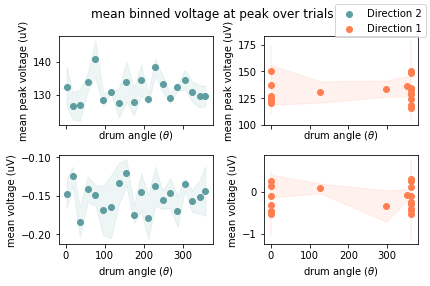

In [41]:
def plot_chunk_data(to_plt_data):
    
    up_peaks_chunk_mean = to_plt_data['up']['peak'][0]
    up_peaks_chunk_std = to_plt_data['up']['peak'][1]
    
    up_v_chunk_mean = to_plt_data['up']['v'][0]
    up_v_chunk_std = to_plt_data['up']['v'][1]
    
    up_mean_loc_per_chunk = to_plt_data['up']['meta'][0] 

    
    down_peaks_chunk_mean = to_plt_data['down']['peak'][0]
    down_peaks_chunk_std = to_plt_data['down']['peak'][1]
    
    down_v_chunk_mean = to_plt_data['down']['v'][0]
    down_v_chunk_std = to_plt_data['down']['v'][1]
    
    down_mean_loc_per_chunk = to_plt_data['down']['meta'][0] 
    
    
    fig, axes = plt.subplots(2,2, sharex=True)

    fig.suptitle('mean binned voltage at peak over trials')


    axes[0][0].scatter(up_mean_loc_per_chunk, 
             up_peaks_chunk_mean , label='Direction 2',c='cadetblue')
    axes[0][0].fill_between(up_mean_loc_per_chunk,
                     up_peaks_chunk_mean+up_peaks_chunk_std, 
                     up_peaks_chunk_mean-up_peaks_chunk_std, 
                     alpha=0.1, color='cadetblue')

    axes[0][0].set_xlabel(r'drum angle ($\theta$)')
    axes[0][0].set_ylabel('mean peak voltage (uV)')

    axes[0][1].scatter(down_mean_loc_per_chunk, 
             down_peaks_chunk_mean, label='Direction 1', c='coral')
    axes[0][1].fill_between(down_mean_loc_per_chunk,
                     down_peaks_chunk_mean+down_peaks_chunk_std, 
                     down_peaks_chunk_mean-down_peaks_chunk_std, 
                     alpha=0.1, color='coral')
    axes[0][1].set_xlabel(r'drum angle ($\theta$)')
    axes[0][1].set_ylabel('mean peak voltage (uV)')


    axes[1][0].scatter(up_mean_loc_per_chunk, 
             up_v_chunk_mean , c='cadetblue')
    axes[1][0].fill_between(up_mean_loc_per_chunk,
                     up_v_chunk_mean+up_v_chunk_std, 
                     up_v_chunk_mean-up_v_chunk_std, 
                     alpha=0.1, color='cadetblue')

    axes[1][0].set_xlabel(r'drum angle ($\theta$)')
    axes[1][0].set_ylabel('mean voltage (uV)')


    axes[1][1].scatter(down_mean_loc_per_chunk, 
             down_v_chunk_mean, c='coral')

    axes[1][1].fill_between(down_mean_loc_per_chunk,
                     down_v_chunk_mean+down_v_chunk_std, 
                     down_v_chunk_mean-down_v_chunk_std, 
                     alpha=0.1, color='coral')

    axes[1][1].set_xlabel(r'drum angle ($\theta$)')
    axes[1][1].set_ylabel('mean voltage (uV)')


    plt.tight_layout()
    fig.legend()
    plt.show()
    
plot_chunk_data(to_plt_data)

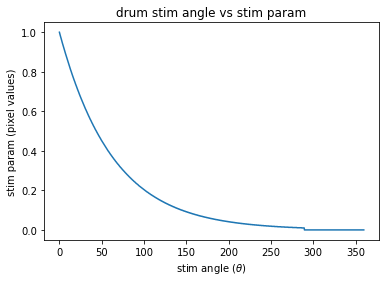

In [42]:
def plot_stim_param_as_a_func_of_theta(strip_n=5): 
    plt.title('drum stim angle vs stim param')
    plt.plot(stim_params[:,0], np.flip(stim_params[:,strip_n]))
    plt.xlabel(r'stim angle ($\theta$)')
    plt.ylabel('stim param (pixel values)')

plot_stim_param_as_a_func_of_theta()

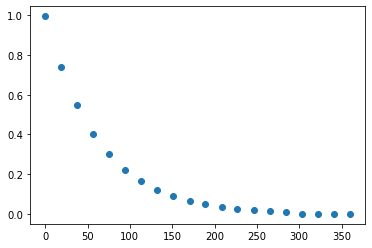

In [43]:
def get_stim_param_chunks(stim_params, strip_n, plot=True, n_chunks=20):
    stim_angle_indxs_per_chunk = np.linspace(1, len(stim_params[:,0])-1, n_chunks, dtype=int)

    if plot:
        plt.scatter(stim_params[:,0][stim_angle_indxs_per_chunk], 
                np.flip(stim_params[:,strip_n])[stim_angle_indxs_per_chunk])

    stim_x = stim_params[:,strip_n][stim_angle_indxs_per_chunk]
    angle_x = stim_params[:,0][stim_angle_indxs_per_chunk]
    
    return angle_x, stim_x

angle_x, stim_x = get_stim_param_chunks(stim_params, 5)

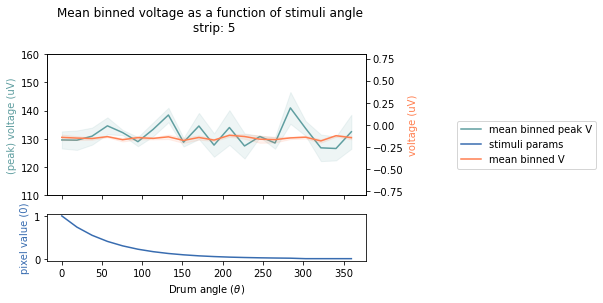

In [71]:
def plot_split_tuning_curve(to_plt_data, stim_params, angle_x, stim_x, strip_n, lim_axis = True):
    
    up_peaks_chunk_mean = to_plt_data['up']['peak'][0]
    up_peaks_chunk_std = to_plt_data['up']['peak'][1]
    
    up_v_chunk_mean = to_plt_data['up']['v'][0]
    up_v_chunk_std = to_plt_data['up']['v'][1]
    
    up_mean_loc_per_chunk = to_plt_data['up']['meta'][0] 

    
    down_peaks_chunk_mean = to_plt_data['down']['peak'][0]
    down_peaks_chunk_std = to_plt_data['down']['peak'][1]
    
    down_v_chunk_mean = to_plt_data['down']['v'][0]
    down_v_chunk_std = to_plt_data['down']['v'][1]
    
    down_mean_loc_per_chunk = to_plt_data['down']['meta'][0] 
    
    fig,ax = plt.subplots(2,1,sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    plt.suptitle('Mean binned voltage as a function of stimuli angle \n strip: {}'.format(strip_n))

    ax[0].plot(angle_x, 
               up_peaks_chunk_mean, label='mean binned peak V', color='cadetblue')
    ax[0].fill_between(angle_x,
                     up_peaks_chunk_mean+up_peaks_chunk_std, 
                     up_peaks_chunk_mean-up_peaks_chunk_std, alpha=0.1, color='cadetblue')
    if lim_axis:
        ax[0].set_ylim(110,160)
    axes1 = ax[0].twinx()

    axes1.plot(angle_x, 
               up_v_chunk_mean, label='mean binned V', color='coral')

    axes1.fill_between(angle_x,
                     up_v_chunk_mean+up_v_chunk_std, 
                     up_v_chunk_mean-up_v_chunk_std, alpha=0.1, color='coral')

    if lim_axis:
        axes1.set_ylim(-.8,.8)
    ax[0].set_ylabel('(peak) voltage (uV)', color='cadetblue')
    axes1.set_ylabel('voltage (uV)', color='coral')


    # plt.plot(stim_x, down_peaks_chunk_mean, label='down')
    # plt.fill_between(stim_x,
    #                  down_peaks_chunk_mean+down_peaks_chunk_std, 
    #                  down_peaks_chunk_mean-down_peaks_chunk_std, alpha=0.1)
    
    ax[1].plot(angle_x, 
               np.flip(stim_x), label='stimuli params', color=colors[5])
    ax[1].set_ylabel('pixel value (0)', color=colors[5])
    plt.tight_layout()
    ax[1].set_xlabel(r'Drum angle ($\theta$)')
    fig.legend(loc='center right', bbox_to_anchor=[1.4,.5])
    plt.show()

plot_split_tuning_curve(to_plt_data, stim_params, angle_x, stim_x, 5)

In [74]:
def run_all_to_plot(f_name, strip_n=5, output=False, plot_verbrose=True, file_type='ccw'):
    
    trace, times, drum_loc, peaks, all_pos_peaks =\
        import_file_get_peaks(f_name, file_type)
    
    if plot_verbrose:
        plot_peak_sorting_outcome(trace, times, drum_loc, peaks, all_pos_peaks)
    
    mean_diffs = print_revolution(trace, times, drum_loc, peaks, all_pos_peaks)
    direction_data = get_all_data(trace, times, drum_loc, peaks, all_pos_peaks, mean_diffs)
    chunk_data = split_to_chunks(direction_data)
    to_plt_data = get_vals_to_plt_avg_chunk_data(chunk_data)
    
    if plot_verbrose:
        plot_chunk_data(to_plt_data)
        
    angle_x, stim_x = get_stim_param_chunks(stim_params, strip_n, plot=plot_verbrose)
    
    plot_split_tuning_curve(to_plt_data, stim_params, angle_x, stim_x, strip_n) 
    
    plot_acf(to_plt_data['up']['peak'][0])
    plt.title('mean binned peak autocorrelation')
    plt.show()

    if output:
        return to_plt_data

In [75]:
def run_all_to_plot_only_first_trial(f_name, strip_n=5, output=False, plot_verbrose=True, file_type='ccw'):
    
    trace, times, drum_loc, peaks, all_pos_peaks =\
        import_file_get_peaks(f_name, file_type)
    
    if plot_verbrose:
        plot_peak_sorting_outcome(trace, times, drum_loc, peaks, all_pos_peaks)
    
    mean_diffs = print_revolution(trace, times, drum_loc, peaks, all_pos_peaks)
    direction_data = get_first_trial_data(trace, times, drum_loc, peaks, all_pos_peaks, mean_diffs)
    chunk_data = split_to_chunks(direction_data)
    to_plt_data = get_vals_to_plt_avg_chunk_data(chunk_data)
    
    if plot_verbrose:
        plot_chunk_data(to_plt_data)
        
    angle_x, stim_x = get_stim_param_chunks(stim_params, strip_n, plot=plot_verbrose)
    
    plot_split_tuning_curve(to_plt_data, stim_params, angle_x, stim_x, strip_n, False) 
    
    plot_acf(to_plt_data['up']['peak'][0])
    plt.title('mean binned peak autocorrelation')
    plt.show()

    if output:
        return to_plt_data
    

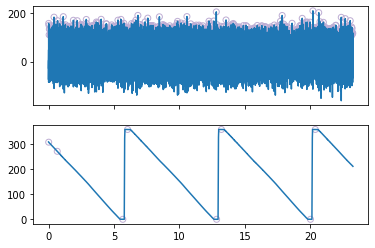

down >>>>
average revolution = 4373.75 ± 1255.34 samples or
                     0.44 ± 0.13 seconds
up <<<<
average revolution = 62029.00 ± 8465.50 samples or
                     6.20 ± 0.85 seconds


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


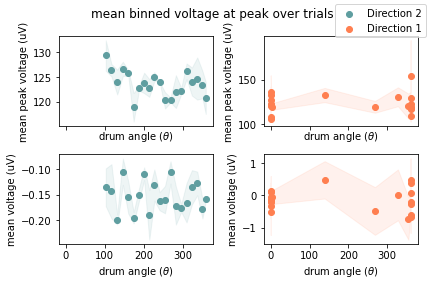

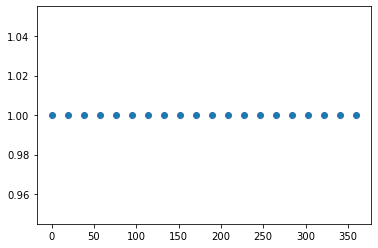

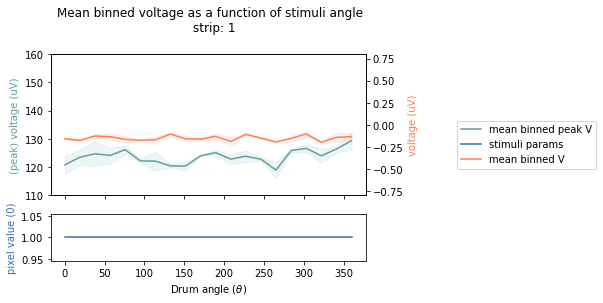

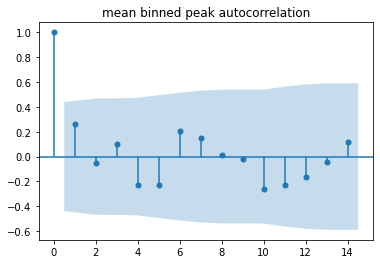

In [76]:
to_plt_data_1 = run_all_to_plot('../../data/5_h1/21o25004.abf', 1, True)  

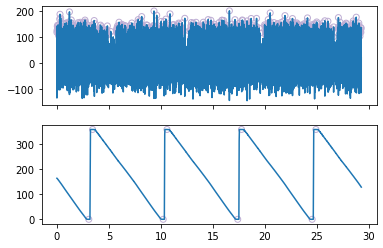

down >>>>
average revolution = 3649.25 ± 13.94 samples or
                     0.36 ± 0.00 seconds
up <<<<
average revolution = 67976.67 ± 63.57 samples or
                     6.80 ± 0.01 seconds


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-40-6bf317caf9b2>:28: RuntimeWarning: Mean of empty slice
  down_peaks_chunk_mean = np.nanmean(avg_peak_voltages_trial_chunk_down, 0)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


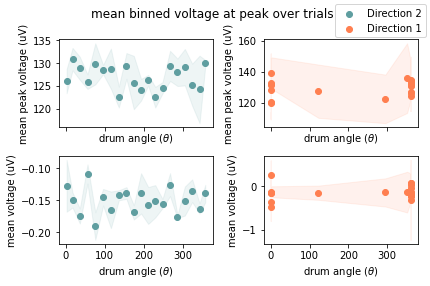

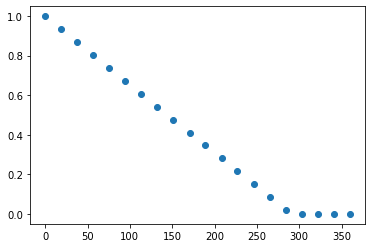

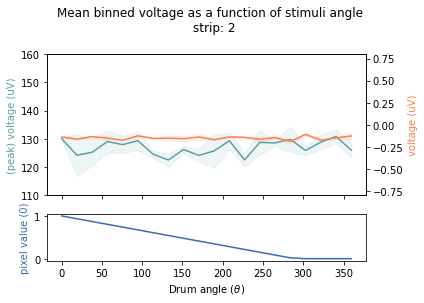

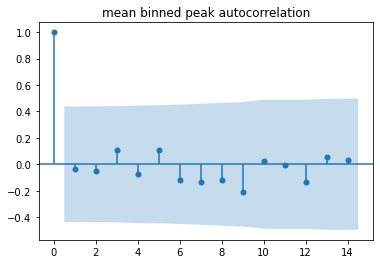

In [47]:
to_plt_data_2 = run_all_to_plot('../../data/5_h1/21o25005.abf', 2, True)  

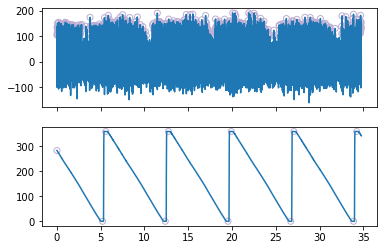

down >>>>
average revolution = 64823.20 ± 6355.69 samples or
                     6.48 ± 0.64 seconds
up <<<<
average revolution = 3653.20 ± 10.91 samples or
                     0.37 ± 0.00 seconds


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


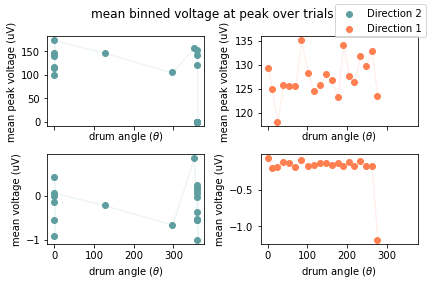

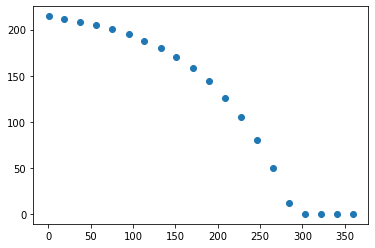

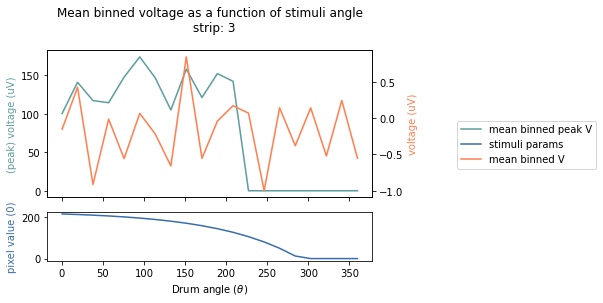

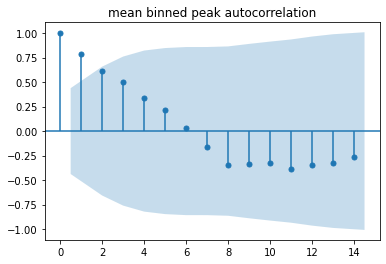

{'up': {'peak': [array([100.4028, 140.9912, 117.1875, ...,   0.    ,   0.    ,   0.    ]),
   array([0., 0., 0., ..., 0., 0., 0.])],
  'v': [array([-0.1509,  0.4259, -0.9122, ..., -0.5193,  0.2445, -0.5513]),
   array([0., 0., 0., ..., 0., 0., 0.])],
  'meta': [[0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    126.51288043011675,
    296.7479663890797,
    351.3929966517857,
    360.0,
    360.0,
    360.0,
    360.0,
    360.0,
    360.0,
    360.0,
    360.0,
    360.0,
    360.0,
    360.0],
   [5.22205,
    5.24025,
    5.25845,
    5.27665,
    5.29485,
    5.31305,
    5.33125,
    5.34945,
    5.36765,
    5.38585,
    5.40405,
    5.422249999999999,
    5.44045,
    5.45865,
    5.476850000000001,
    5.49505,
    5.513199999999999,
    5.5313,
    5.5493999999999994,
    5.5675]]},
 'down': {'peak': [array([123.402 , 132.8624, 129.7274, ..., 118.1946, 124.9084, 129.364 ]),
   array([0., 0., 0., ..., 0., 0., 0.])],
  'v': [array([-1.1797, -0.1807, -0.1792, ..., -0.1885, -0

In [77]:
#to_plt_data_3 = run_all_to_plot('../../data/5_h1/21o25006.abf', 3, True)  
run_all_to_plot_only_first_trial('../../data/5_h1/21o25006.abf', 3, True)  

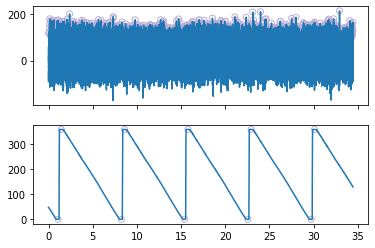

down >>>>
average revolution = 3657.20 ± 6.76 samples or
                     0.37 ± 0.00 seconds
up <<<<
average revolution = 67987.25 ± 58.19 samples or
                     6.80 ± 0.01 seconds


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


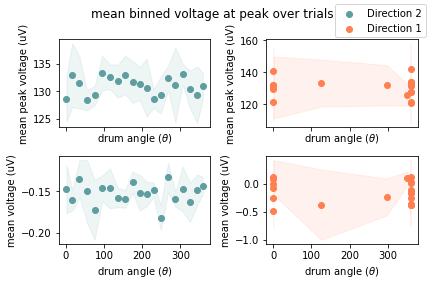

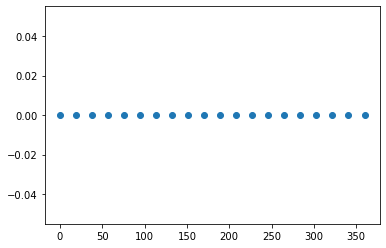

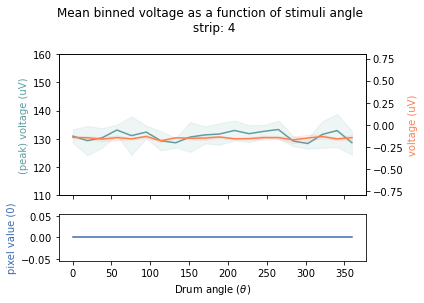

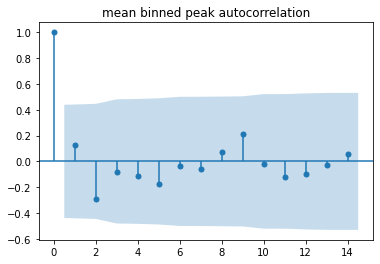

In [67]:
to_plt_data_4 = run_all_to_plot('../../data/5_h1/21o25009.abf', 4, True)  

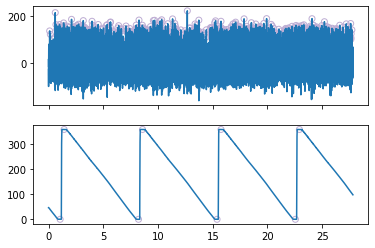

down >>>>
average revolution = 3648.00 ± 5.61 samples or
                     0.36 ± 0.00 seconds
up <<<<
average revolution = 67995.33 ± 60.05 samples or
                     6.80 ± 0.01 seconds


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-16-6bf317caf9b2>:28: RuntimeWarning: Mean of empty slice
  down_peaks_chunk_mean = np.nanmean(avg_peak_voltages_trial_chunk_down, 0)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


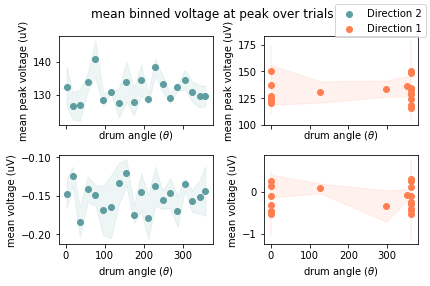

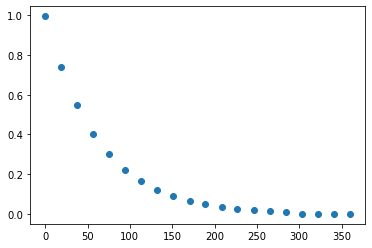

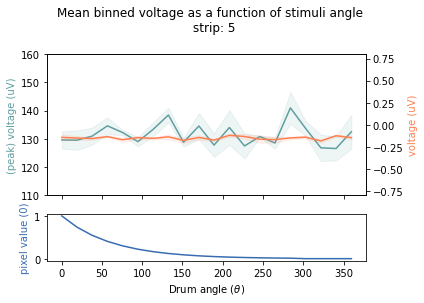

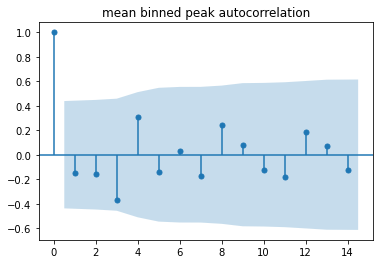

In [29]:
to_plt_data_5 = run_all_to_plot('../../data/5_h1/21o25011.abf', 5, True)  

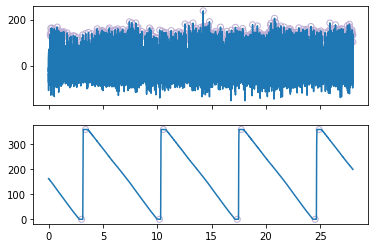

down >>>>
average revolution = 3651.25 ± 4.44 samples or
                     0.37 ± 0.00 seconds
up <<<<
average revolution = 68011.00 ± 17.20 samples or
                     6.80 ± 0.00 seconds


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-16-6bf317caf9b2>:28: RuntimeWarning: Mean of empty slice
  down_peaks_chunk_mean = np.nanmean(avg_peak_voltages_trial_chunk_down, 0)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


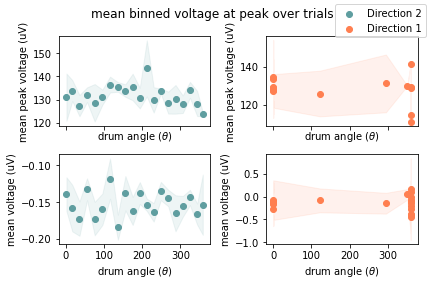

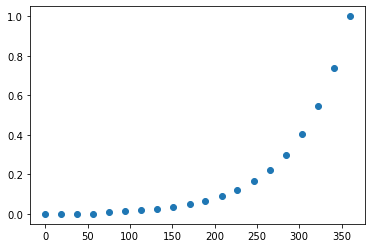

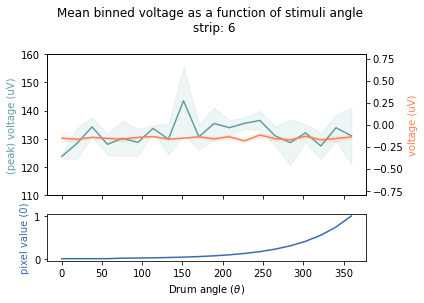

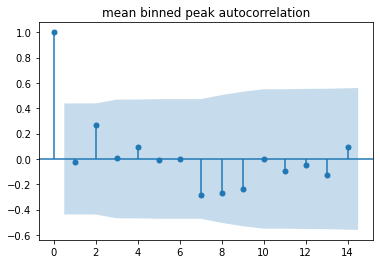

In [30]:
to_plt_data_6 = run_all_to_plot('../../data/5_h1/21o25010.abf', 6, True)  

0 0
0.04956647047228124
0 1
0.04220581416334379
0 2
0.025561477100416785
0 3
0.02998141509395036
0 4
0.06265449573070359
0 5
0.03493304439431599
0 6
0.16089669163203757
0 7
0.02295730589467604
0 8
-0.0004959182256167871
0 9
-0.00021392037817280496
1 0
0.020428534202651782
1 1
0.049566470472283686
1 2
0.042205814163347344
1 3
0.025561477100419783
1 4
0.02998141509395158
1 5
0.06265449573070192
1 6
0.03493304439431599
1 7
0.1608966934097844
1 8
0.022957305894675928
1 9
-0.000495918225616343
2 0
-0.004638715802919302
2 1
0.02042853420264812
2 2
0.0495664831762076
2 3
0.04220581416334146
2 4
0.025561477100415342
2 5
0.02998141509394725
2 6
0.0626544957306997
2 7
0.03493304439431155
2 8
0.16089668947282476
2 9
0.02295731415311497
3 0
0.0835117947005376
3 1
-0.00463871580291686
3 2
0.020428535539511183
3 3
0.04956647047228213
3 4
0.042205814163343125
3 5
0.02556147710041612
3 6
0.029981415093946917
3 7
0.06265449573070214
3 8
0.03493304439431033
3 9
0.1608966934097832
4 0
-0.0064014584682798

Text(0, 0.5, '5a')

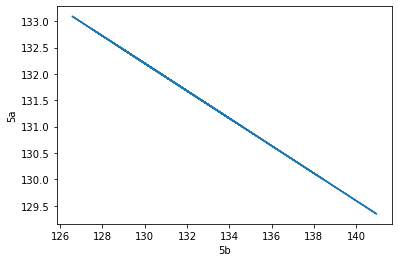

In [229]:
from sklearn.metrics import r2_score, explained_variance_score

x_f = lambda x, a, b: x*a + b

for i in range(10):
    for j in range(10):
        x1 = np.roll(to_plt_data_5['up']['peak'][0],i)
        x2 = np.roll(to_plt_data_6['up']['peak'][0],j)

        opt_p,_ = sp.optimize.curve_fit(x_f, x1, x2)

        print(i,j)
        print(r2_score(x1, x_f(x2, *opt_p)))
#plt.scatter(x1,x2)        
plt.plot(x1, x_f(x1, *opt_p))
plt.xlabel('5b')
plt.ylabel('5a')

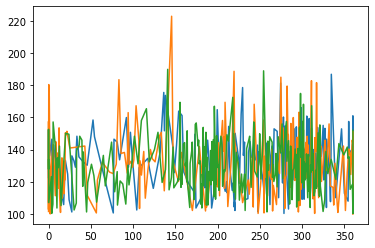

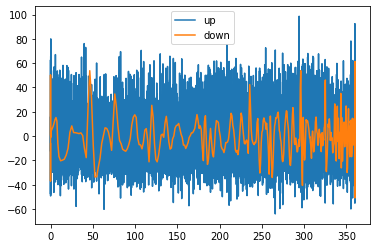

In [70]:
### trying some plots
# down_trace_peaks_trials = [find_peaks(down_trial, height=100, 
#                          prominence=20, wlen=5)[0]
#            for down_trial in  down_trace_trials]


# up_trace_peaks_trials = [find_peaks(up_trial, height=100, 
#                          prominence=20, wlen=5)[0]
#            for up_trial in  up_trace_trials]

# for v,peak_time, loc in zip(up_trace_trials, up_trace_peaks_trials, up_loc_trials):
#     plt.plot(loc[peak_time], v[peak_time])
#     up_peak_ifr = get_ifr(peak_time)
#     #plt.plot(loc[peak_time][1:],up_peak_ifr)

# plt.show()    
# #np.mean([a[b] for a,b in zip(up_trace_trials, up_trace_peaks_trials)])
# # for down_trial, down_loc in  zip(down_trace_trials,down_loc_trials):
# #     down_peaks = find_peaks(down_trial, height=100, 
# #                          prominence=20, wlen=5)[0]
# #     down_ifr = get_ifr(down_peaks)
# #     plt.plot(down_loc[down_peaks][1:], down_ifr)

# # plt.show()   

# # for up_trial in  up_trace_trials:
# #     up_peaks = find_peaks(up_trial, height=100, 
# #                          prominence=20, wlen=5)[0]
# #     up_ifr = get_ifr(up_peaks)
# #     plt.plot(up_ifr)
    
# # for i in [up_peaks_per_trial]:
# #     plt.plot(i)

# # plt.show()
# # for i in b:
# #     plt.plot(i)
# plt.plot(np.mean(up_loc_trials,axis=0), np.mean(up_trace_trials,axis=0), label='up')
# plt.plot(np.mean(down_loc_trials,axis=0), np.mean(down_trace_trials,axis=0), label='down')
# plt.legend()
# # trace comparison mean over trials ploted as a function of drum angle

../../data/5_h1/21o25003.abf


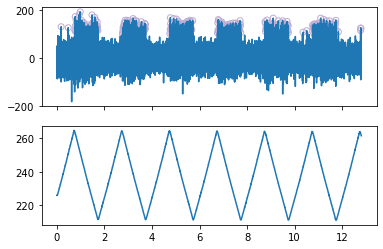

../../data/5_h1/21o25002.abf


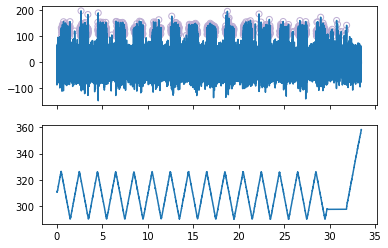

../../data/5_h1/21o25001.abf


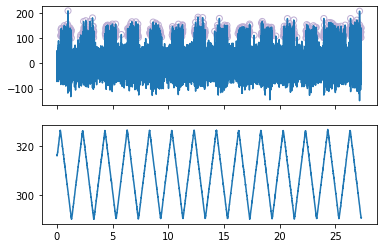

../../data/5_h1/21o25005.abf


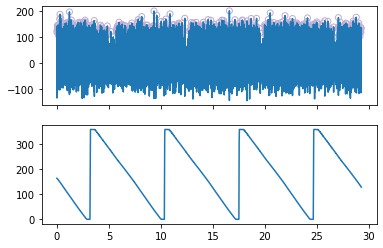

../../data/5_h1/21o25011.abf


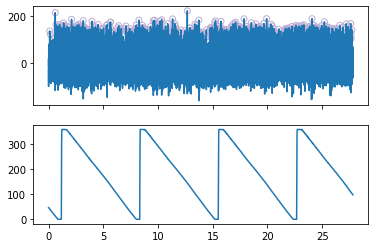

../../data/5_h1/21o25010.abf


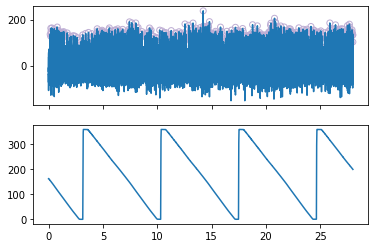

../../data/5_h1/21o25004.abf


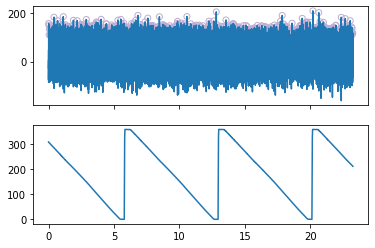

../../data/5_h1/21o25006.abf


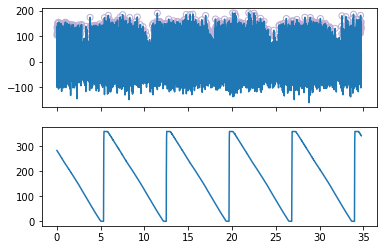

../../data/5_h1/21o25007.abf


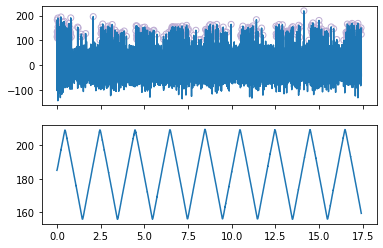

../../data/5_h1/21o25009.abf


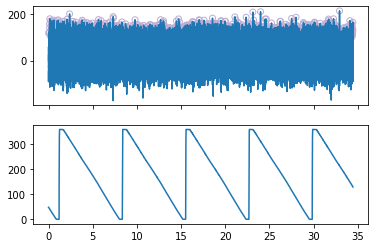

../../data/5_h1/21o25008.abf


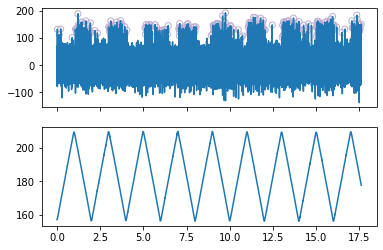

In [179]:
for file in glob.glob('../../data/5_h1/*.abf'):
    print(file)
    data = extract_paired(file)
    
    trace = -1*data['data'][1]
    times = data['data'][0]
    drum_loc = degrees_from_Vs(data['data'][2])
    peaks, properties = find_peaks(trace, height=100, 
                                   prominence=20, wlen=5)  
    peak_heights = trace[peaks] 
    peak_times = trace[peaks] 

    fig, axes = plt.subplots(2,1, sharex=True)

    axes[0].plot(times, trace)
    axes[0].scatter(times[peaks], trace[peaks],
               facecolors='none', edgecolors=colors[2], 
                label='peaks')
    axes[1].plot(times, drum_loc)
    plt.show()
    